# Verlet List

We discussed in the first worksheet that force calculation takes most of the time during molecular dynamics simulation. Therefore, to speed up the simulation, we need to improve the algorithm we use for the force calculation. <br/><br/>
The naive direct particle to particle interaction has complexity $\mathcal{O}(N^2)$. We will now have a look at methods that will reduce the complexity. <br/>
Firstly, we will discuss the **Verlet list**. There are many short-range potentials like LJ potential (as shown in the figure below). For each molecule, an influence volume (closed sphere) with a cut-off radius $r_c$ can be assumed. Every molecule outside this influence volume can be neglected as its impact on the force is negligible. 
<p align="center">
<img src="./figures/LJforce.png"
     alt="Pendulum Force Diagram"
     width="356" height="356"/>
</p>
Therefore, during the calculation of the pairwise forces, we only need to consider the molecules within this sphere. When this cutoff is chosen concerning the total number of particles, it can be shown that the complexity of the algorithm is only $\mathcal{O}(N)$. The list of particles that are within the range of a particle is this particle's Verlet list.<br/><br/>
However, there remains the question of how to find the molecules that are within the cut-off radius of one particular molecule. For this, we need to calculate the distance between the molecule and all other molecules. So, the complexity to make the Verlet list for one molecule is still $\mathcal{O}(N)$, There are $N$ molecules, hence, the complexity of creating all the Verlet lists is still $\mathcal{O}(N^2)$. This raises the complexity of the overall algorithm $\mathcal{O}(N^2)$ and defeats the purpose of decreasing the complexity of the algorithm. <br/>
To reduce the impact of this expensive operation, we do not calculate the Verlet list during every time step. Rather, we create the Verlet lists every $n_{upd}$ time step. Over the course of these time steps, some new molecules might enter the cut-off radius. To compensate for that, we increase the radius by an amount $r_{skin}$. The lower bound of $r_{skin}$ is as following: $$r_{skin} > n_{upd} \Delta t v_m$$ 
where $v_m$ is the mean velocity of all molecules and $\Delta t$ is the size of the time step. We call the sum of $r_c + r_{skin}$ neighbor list radius.
<br\><br\>
Let us consider example in the figure shown below:
<p align="center">
<img src="./figures/verlet_list_1.png"
     alt="Pendulum Force Diagram"
     width="356" height="356"/>
</p>
All the molecules except the red-colored molecules are added to the Verlet list. Their distance to the black particle has to be evaluated in every time step. In the shown situation, however, the blue particles are further away from the black particle than $r_c$ and should not be considered for the force calculation.

### Worksheet description
In this worksheet we will just consider one time step. We will use the Verlet list algorithm to calculate the the pairwise Lennard Jones Potential:
$$U = 4 \epsilon \left( \left( \frac{\sigma}{d}\right)^{12} -  \left( \frac{\sigma}{d}\right)^6 \right)  = \frac{C_1}{d^{12}} - \frac{C_2}{d^6}$$
where $C_1$ and $C_2$ are constants.
We consider $N$ molecules with two dimensional domain $[0,1]^2$. 
Let $C_1 = 10^{-15}$ and $C_2 = 10^{-5}$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import time

# size of the domain in each dimension
domain_size=1
# number of particles
N=30
# cutoff
r_c = 0.2
# Verlet skin
r_s = 0.01

The following code defines the Lennard Jones Potential as given above:

In [2]:
def lj_potential(distance, c1=1e-15, c2=1e-5):
    return (c1 / distance**12) - (c2 / distance**6)

print("Potential when distance is 0.01:  ", lj_potential(0.01))
print("Potential when distance is 0.4:  ", lj_potential(0.2))

Potential when distance is 0.01:   989999999.9999998
Potential when distance is 0.4:   -0.15624975585937495


The following code defines a Particle which is modeled as a point:

In [3]:
class Particle():
    """Particle represented as a point.".
    
    Attributes:
        x, y: coordinates of the particle.
        m: mass of the particle.
        phi: the gravitational potential of the particle.
    """
    
    def __init__(self, coords=[], domain=domain_size, m=1.0):
        # depending on the arguments either set the point to the given coordinates
        # or generate random coordinates within the given domain.
        if coords:
            assert len(coords) == 2, "we expect 2D coords."
            self.x = coords[0]
            self.y = coords[1]
        else:
            self.x = domain * np.random.random()
            self.y = domain * np.random.random()
        self.m = m
        self.phi = 0.
        self.verlet_list = []
        
        
# Helper functions:
def distance(a, b):
    return np.sqrt((a.x-b.x)**2 + (a.y-b.y)**2)

def plot_particles(particles, indices=[], marker='o', color='r', s=10, cmap='gist_rainbow' ):
    if not indices:
        indices = list(range(0,len(particles)))
    allX = np.zeros(len(indices), dtype=float)
    allY = np.zeros(len(indices), dtype=float)
    for i, idx in enumerate(indices):
        particle = list_particles[idx]
        allX[i] = particle.x
        allY[i] = particle.y
    plt.scatter(allX, allY, marker=marker, c=color, s=s, cmap=cmap)
    plt.xlim(left=0, right=domain_size)
    plt.ylim(bottom=0, top=domain_size)

Let us create $N$ randomly distributed particles and plot them.

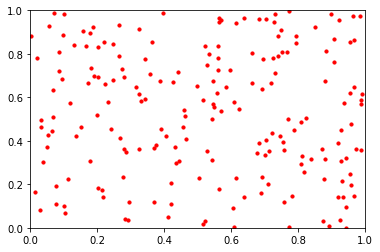

In [4]:
N = 200
list_particles = []
for i in range(N):
    list_particles.append(Particle())
    
# plotting
plot_particles(list_particles)

### Task 1 Direct Sum
Complete the implementation of the function that calculates the direct particle to particle interaction. The function takes a list of particles as a parameter and returns a NumPy array containing the potential of the corresponding particle in the list.

In [5]:
# %load solution_task1_directSum.py
def direct_interaction(list_particles):
    """Calculates an array which contains the potential of each particle
    using the direct particle-particle summation method.
    Parameter
    ---------
    list_particles : list
        List of Particle objects. This is the list of all the particles in the simulation.
    Return
    ------
    potential : numpy ndarray
        List containing the potential of each particle in the same order as the input.
    """
    potential = np.zeros(len(list_particles), dtype=float)
    ######## TODO BEGINS #############
    for i, p_i in enumerate(list_particles):
        for j, p_j in enumerate(list_particles):
            if i != j:
                d = distance(p_i, p_j)
                potential[i] += lj_potential(d)
    
    
    ######### TODO ENDS ##############
    return potential


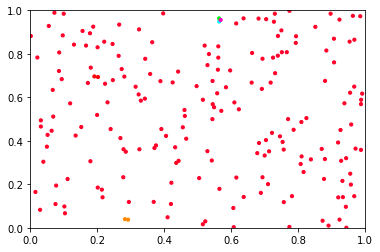

In [6]:
# Do the force calculation
direct_potential = direct_interaction(list_particles)
# Plot all particles colord by force
# WARNING: If particles are very close the color map will be skewed
plot_particles(list_particles, color=direct_potential)

### Task 2 Generating Verlet Lists
Complete the implementation of the function that creates the Verlet list of a particle.

In [7]:
# %load solution_task2_updateVerletLists.py
def update_verlet_list(p_i, list_particles, nl_radius):
    """Updates the verlet list of a particle
    Parameter
    ---------
    p_i : object of type Particle
        Particle object for which we need to updatet the verlet list
    list_particles : list
        List of Particle objects. This is the list of all the particles in the simulation.
    nl_radius : float
        Cut-off radius + skin (default value here is 0.1)
    """
    p_i.verlet_list = [] # add the index(position of particle) that is less than rc
    ######## TODO BEGINS #############
    for index_j, p_j in enumerate(list_particles):
        d = distance(p_i, p_j)
        if d > 0 and d < nl_radius:
            p_i.verlet_list.append(index_j)
    
    
    ######### TODO ENDS ##############


Update the verlet list for all the particles

In [8]:
for p_i in list_particles:
    update_verlet_list(p_i, list_particles, r_c+r_s)

Let's visulize the verlet list of a randomly chosen particle

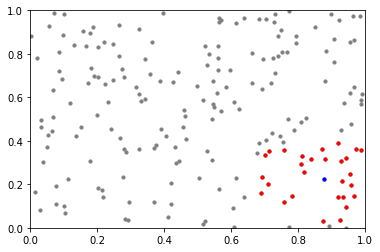

In [9]:
# plot all particles in gray
plot_particles(list_particles, color='gray')

# choose one particle i randomly
i = np.random.randint(low=0, high=len(list_particles)-1, size=1)[0]
# print all its neighbors in red
verlet_list_i = list_particles[i].verlet_list
plot_particles(list_particles, indices=verlet_list_i, color='r')
# and itself in blue
plot_particles(list_particles, indices=[i], color='b')

### Task 3 Pairwise Interaction through Verlet Lists
Complete the implementation of the function that calculates the potential of a particle by interacting it with all particles which are in its Verlet list.

In [10]:
# %load solution_task3_potential.py
def one_particle_potential_verlet(p_i, list_particles, r_c):
    """Calculates the total potential of one particle.
    Parameter
    ---------
    p_i: Particle
        Particle for which to calculate the potential.
    list_particles : list
        List of Particle objects. This is the list of all the particles in the simulation.
    r_c: float
        Cutoff radius of the potential.
    Return
    ------
    potential : float
        The potential of p_i.
    """
    potential = 0.0
    ######## TODO BEGINS #############
    for j in p_i.verlet_list:
        p_j = list_particles[j]
        d = distance(p_i, p_j)
        if d < r_c:
            potential += lj_potential(d)
    
    
    ######### TODO ENDS ##############
    return potential


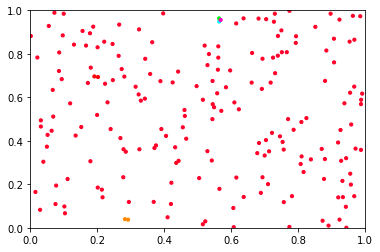

In [11]:
def all_particle_potential_verlet(list_particles, r_c):
    potentials = np.zeros(len(list_particles), dtype=float)
    for idx, particle in enumerate(list_particles):
        potentials[idx] = one_particle_potential_verlet(particle, list_particles, r_c)
    return potentials

verlet_potential = all_particle_potential_verlet(list_particles, r_c)
plot_particles(list_particles, color=verlet_potential)

Let us observe the mean relative error

In [15]:
print("Mean relative error", 
      np.linalg.norm((verlet_potential- direct_potential)/direct_potential, 2)/len(list_particles))

Mean relative error 1.3557270412035135e-05


## Error and evaluation time plots

Firstly, we will analyze how the time for the computation of the pairwise interaction changes with an increasing number of particles for a fixed cut-off radius.

In [12]:
# Particle numbers we want to evaluate
num_particles = [int(100 * i) for i in range(1,11)]

# Arrays where we want to collect data
error = np.zeros(len(num_particles), dtype=float)
time_direct = np.zeros(len(num_particles), dtype=float)
time_verlet = np.zeros(len(num_particles), dtype=float)

for idx, N in enumerate(num_particles):
    list_particles = []
    # Generate N random particles
    for i in range(N):
        list_particles.append(Particle())
    # Pairwise calculation via direct sum
    direct_start = time.time()
    direct_potential = direct_interaction(list_particles)
    direct_end = time.time()
    time_direct[idx] = direct_end - direct_start
    # Pairwise calculation via Verlet list
    # Update Verlet lists
    for p in list_particles:
        update_verlet_list(p, list_particles, r_c+r_s)
    # Calculate potential
    verlet_start = time.time()
    verlet_potential = all_particle_potential_verlet(list_particles, r_c)
    verlet_end = time.time()
    time_verlet[idx] = verlet_end - verlet_start
    error[idx] = np.linalg.norm((direct_potential - verlet_potential) / direct_potential) / N  

Let's plot the results:

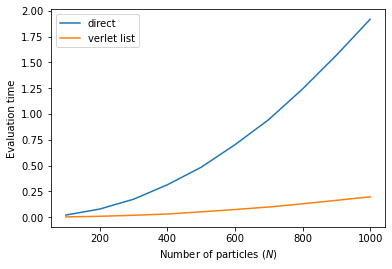

In [14]:
fig = plt.figure()
plt.plot(num_particles, time_direct, label='direct')
plt.plot(num_particles, time_verlet, label='verlet list')
plt.ylabel('Evaluation time')
plt.xlabel('Number of particles ($N$)')
plt.legend()
plt.show()

### Question
What is the (approximate) slope of each line? What does it tell you about the complexity of the algorithms under observation?

Now, we will observe how the evaluation time and error evolves with increase in cut-off radius for fixed number of particles

In [16]:
# Number of particles
N = 500
# Generate N random particles
list_particles = []
for i in range(N):
    list_particles.append(Particle())

# Pairwise calculation via direct sum
direct_start = time.time()
direct_potential = direct_interaction(list_particles)
direct_end = time.time()
direct_time = direct_end - direct_start
r_c = [0.01, 0.05, 0.1, 0.2, 0.4, 0.8]
time_verlet_evaluation = np.zeros(len(r_c), dtype=float)
error_verlet = np.zeros(len(r_c), dtype=float)
# Pairwise calculation via Verlet lists with different r_c
for idx, r in enumerate(r_c):
    # Update Verlet lists
    for p in list_particles:
        update_verlet_list(p, list_particles, nl_radius=r+r_s)
    # Calculate potential
    verlet_start = time.time()
    verlet_potential = all_particle_potential_verlet(list_particles, r)
    verlet_end = time.time()
    time_verlet_evaluation[idx] = verlet_end - verlet_start
    error_verlet[idx] = np.linalg.norm((direct_potential - verlet_potential) / direct_potential) / N  

Let's plot the results:

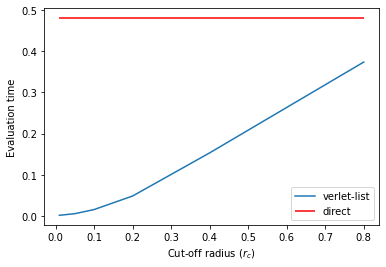

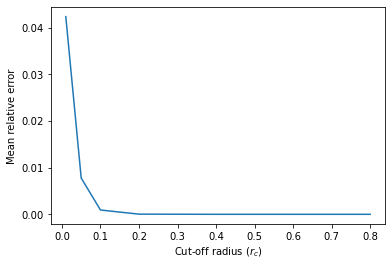

In [17]:
plt.ylabel('Evaluation time')
plt.xlabel('Cut-off radius ($r_c$)')
plt.hlines(direct_time, r_c[0], r_c[-1], label='direct', color='r')
plt.plot(r_c, time_verlet_evaluation, label='verlet-list')
plt.legend(loc='lower right')
plt.show()
plt.ylabel('Mean relative error')
plt.xlabel('Cut-off radius ($r_c$)')
plt.plot(r_c, error_verlet)
plt.show()

### Question
1. Explain the behavior of both the graphs.
2. What should be the smallest value for the cut-off radius for which there will be no error (error=0)?